# ***Business Understanding***
- The primary objective of this NLP project is to develop a robust clssification model capable of accurately distingushing between real and fake news articles based on their textual content.
- By automating the process of identifying fake news, we aim to combat the spread of misinformation and provide users with reliable and trustworthy source of information.

In [1]:
# Importing linraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
# Loading the dataset
df = pd.read_csv("real_fake_sample.csv")
df.head()

,Text,label
0,WATCH: Bill Maher Hilariously Explains Why Tr...,Fake
1,China defends ally Pakistan after Trump critic...,Real
2,"Trudeau Does What Trump Can’t, Calls Out Whit...",Fake
3,WATCH: Trump Crudely HUMILIATED A Woman Onsta...,Fake
4,U.S. lawmakers seek looser energy development ...,Real


# ***Data Understanding***

- Datset consists of two main columns:
    1. Text : This column consists the textual content of news articles.
    2. Label : This binary column indicates whether news article is categorized as real or fake.

In [3]:
df.shape

(1500, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1500 non-null   object
 1   label   1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [5]:
df.isna().sum()

Text     0
label    0
dtype: int64

In [6]:
df.duplicated().sum()

1

In [3]:
# Droping the dulplicates rows.
df.drop_duplicates(inplace = True)

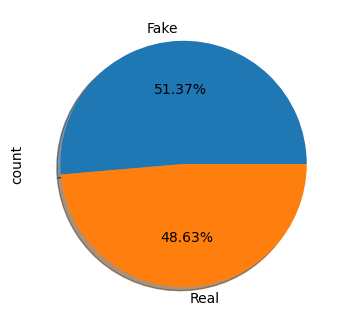

In [8]:
plt.figure(figsize = (6, 4))
df["label"].value_counts().plot(kind = "pie", autopct = "%0.02f%%", shadow = True)
plt.show()

Fake class consists 51% and Real class consists 48.6%.

# ***Data Preprocessing***

In [4]:
# Importing nltk libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# loading the Lemmatizer
wnl = WordNetLemmatizer()

In [15]:
# Calculating the number of words and sentences present in text feature.
df["Word_len"] = df["Text"].apply(lambda x : len(nltk.word_tokenize(x)))
df["Sent_len"] = df["Text"].apply(lambda x : len(nltk.sent_tokenize(x)))

**Text Cleaning**

In [5]:
def text_cleaning(clean):
    rf = re.sub("[^A-Za-z0-9]", " ", clean)
    rf = rf.lower()
    rf = rf.split()
    rf = [wnl.lemmatize(word) for word in rf if not word in set(stopwords.words("english"))]
    rf = " ".join(rf)
    return rf

In [6]:
df["Clean_text"] = df["Text"].apply(text_cleaning)

In [12]:
# Importing wordcloud to see the common words in real and fake
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = "white")

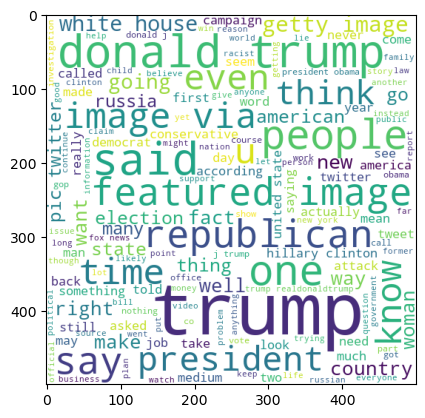

In [13]:
# Common words in Fake class.
span_wc = wc.generate(df[df["label"] == "Fake"]["Clean_text"].str.cat(sep = " "))
plt.imshow(span_wc)
plt.show()

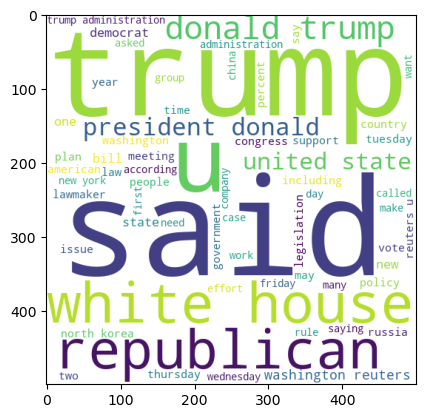

In [15]:
# Common words in Real class
span_wc = wc.generate(df[df["label"] == "Real"]["Clean_text"].str.cat(sep = " "))
plt.imshow(span_wc)
plt.show()

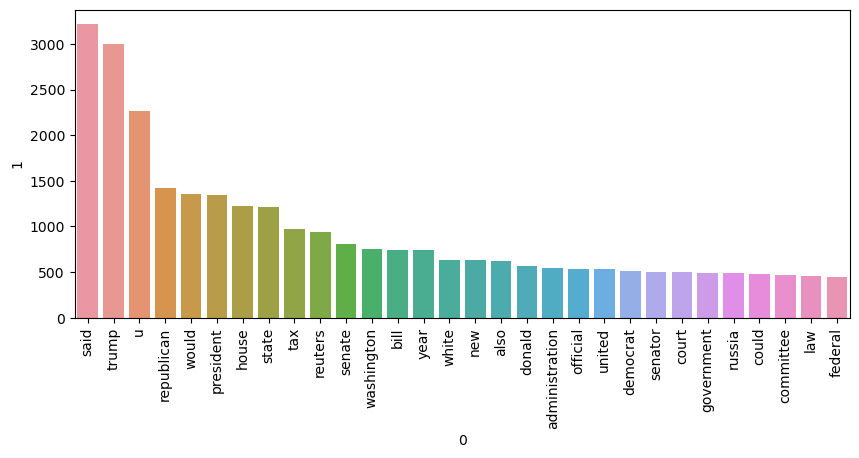

In [16]:
# Fetching the highest 30 values for Real
real_corpus = []
for msg in df[df["label"] == "Real"]["Clean_text"].to_list():
    for word in msg.split():
        real_corpus.append(word)
        
from collections import Counter      
plt.figure(figsize = (10, 4))
sns.barplot(x = pd.DataFrame(Counter(real_corpus).most_common(30))[0],y = pd.DataFrame(Counter(real_corpus).most_common(30))[1])
plt.xticks(rotation = "vertical")
plt.show()

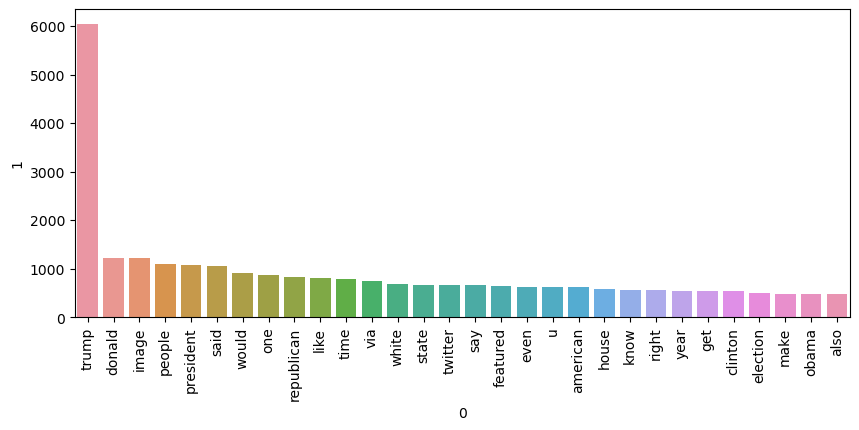

In [17]:
fake_corpus = []
for msg in df[df["label"] == "Fake"]["Clean_text"].to_list():
    for word in msg.split():
        fake_corpus.append(word)
        
from collections import Counter      
plt.figure(figsize = (10, 4))
sns.barplot(x = pd.DataFrame(Counter(fake_corpus).most_common(30))[0],y = pd.DataFrame(Counter(fake_corpus).most_common(30))[1])
plt.xticks(rotation = "vertical")
plt.show()

**Feature Encoding**

In [7]:
df["label"].replace({"Fake": 0, "Real": 1}, inplace = True)

**Vectorization**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [9]:
X = cv.fit_transform(df["Clean_text"]).toarray()

In [11]:
import pickle
with open("new_classifier_vectorizer.pickle", "wb") as f:
    pickle.dump(cv, f)

In [21]:
y = df["label"]

**Importing Models & Metrics**

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB 

**Train Test Split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

**GridSearchCV & Model - MultinomialNB**

In [27]:
estimator = MultinomialNB()

param_grid = {"alpha": [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'alpha': 7}

In [30]:
mnb_model = MultinomialNB(alpha = 7)
mnb_model.fit(X_train, y_train)
pred_train = mnb_model.predict(X_train)
pred_test = mnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9833194328607172
Testing Accuracy : 0.9666666666666667
ROC AUC Score : 0.9668803418803419
Confusion Matrix
[[140   4]
 [  6 150]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       144
           1       0.97      0.96      0.97       156

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



**Model - BernoulliNB**

In [32]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)
pred_train = bnb_model.predict(X_train)
pred_test = bnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9991659716430359
Testing Accuracy : 0.9866666666666667
ROC AUC Score : 0.9863782051282052
Confusion Matrix
[[141   3]
 [  1 155]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       144
           1       0.98      0.99      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**Model - GaussianNB**

In [33]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
pred_train = gnb_model.predict(X_train)
pred_test = gnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.8766666666666667
ROC AUC Score : 0.8795405982905983
Confusion Matrix
[[137   7]
 [ 30 126]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       144
           1       0.95      0.81      0.87       156

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300



**Model - LogisticRegression**

In [34]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
pred_train = logistic_model.predict(X_train)
pred_test = logistic_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9866666666666667
ROC AUC Score : 0.9863782051282052
Confusion Matrix
[[141   3]
 [  1 155]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       144
           1       0.98      0.99      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**Model - SVM**

In [35]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
pred_train = svm_model.predict(X_train)
pred_test = svm_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.99
ROC AUC Score : 0.9895833333333333
Confusion Matrix
[[141   3]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       144
           1       0.98      1.00      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**GridSearchCV & Model - DecisionTree**

In [36]:
decision_model = DecisionTreeClassifier()
decision_model.fit(X_train, y_train)
pred_train = decision_model.predict(X_train)
pred_test = decision_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9966666666666667
ROC AUC Score : 0.9965277777777778
Confusion Matrix
[[143   1]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       0.99      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - RandomForestClassifier**

In [39]:
estimator = RandomForestClassifier()

param_grid = {"n_estimators": list(range(29, 40))}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'n_estimators': 35}

In [40]:
random_model = RandomForestClassifier(n_estimators = 35)
random_model.fit(X_train, y_train)
pred_train = random_model.predict(X_train)
pred_test = random_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9933333333333333
ROC AUC Score : 0.9933226495726496
Confusion Matrix
[[143   1]
 [  1 155]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       144
           1       0.99      0.99      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**GridSearchCV & Model - AdaBoostClassifier**

In [41]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
pred_train = ada_model.predict(X_train)
pred_test = ada_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - GradientBoostingClassifier**

In [42]:
gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train, y_train)
pred_train = gradient_model.predict(X_train)
pred_test = gradient_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9966666666666667
ROC AUC Score : 0.9965277777777778
Confusion Matrix
[[143   1]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       0.99      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - KNN**

In [43]:
estimator = KNeighborsClassifier()

param_grid = {"n_neighbors": list(range(1, 10))}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'n_neighbors': 2}

In [44]:
svm_model = KNeighborsClassifier(n_neighbors = 2)
svm_model.fit(X_train, y_train)
pred_train = svm_model.predict(X_train)
pred_test = svm_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9824854045037531
Testing Accuracy : 0.67
ROC AUC Score : 0.6591880341880342
Confusion Matrix
[[ 56  88]
 [ 11 145]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.39      0.53       144
           1       0.62      0.93      0.75       156

    accuracy                           0.67       300
   macro avg       0.73      0.66      0.64       300
weighted avg       0.72      0.67      0.64       300



# ***Result Interpretation***

In [60]:
accuracy = pd.DataFrame(
    np.array([["MultinomialNB", 98, 96, 96, 97, 97, 97],
             ["BernoulliNB", 99, 98, 98, 99, 99, 99],
             ["GaussianNB", 100, 87, 87, 88, 88, 88],
             ["Logistic",100, 98, 98, 99, 99, 99],
             ["KNN", 98, 67, 65, 73, 66, 64],
             ["SVM", 100, 99, 98, 99, 99, 99],
             ["Decision Tree", 100, 99, 99, 100, 100, 100],
             ["Random Forest", 100, 99, 99, 99, 99, 99],
             ["AdaBoost", 100, 100, 100, 100, 100, 100],
             ["GradientBoosting", 100, 99, 99, 100, 100, 100]
             ]),
    columns = ["Model", "Train Accuracy", "Test Accuracy", "ROC_AUC", "Precision", "Recall", "F1 Score"]
)

accuracy

,Model,Train Accuracy,Test Accuracy,ROC_AUC,Precision,Recall,F1 Score
0,MultinomialNB,98,96,96,97,97,97
1,BernoulliNB,99,98,98,99,99,99
2,GaussianNB,100,87,87,88,88,88
3,Logistic,100,98,98,99,99,99
4,KNN,98,67,65,73,66,64
5,SVM,100,99,98,99,99,99
6,Decision Tree,100,99,99,100,100,100
7,Random Forest,100,99,99,99,99,99
8,AdaBoost,100,100,100,100,100,100
9,GradientBoosting,100,99,99,100,100,100


- AdaBoost is predicting with an accuracy of 100%. So, we will consider AdaBoost as a final model.

# ***Final Model - AdaBoost***

In [141]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
pred_train = logistic_model.predict(X_train)
pred_test = logistic_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**Predicting New Value**

In [65]:
news = input("Enter the news :")

new_data = pd.DataFrame({"news": news}, index = [0])

def clean_texting(text):
    rf = re.sub("[^A-Za-z0-9]", " ", text)
    rf = rf.lower()
    rf = rf.split()
    rf = [wnl.lemmatize(word) for word in rf if not word in set(stopwords.words("english"))]
    rf = " ".join(rf)
    return rf

new_data["news"] = new_data["news"].apply(clean_texting)

nm = cv.transform(new_data["news"]).toarray()

result = mp.predict(nm)[0]

print("===============================")
if result == 0:
    print("This news is fake.")
elif result == 1:
    print("This news is real.")

Enter the news : china defends ally pakistan trump criticism beijing reuters china defended ally pakistan tuesday u president donald trump said united state could longer silent pakistan safe haven militant warned much lose continuing harbor terrorist trump monday committed united state open ended conflict afghanistan signaling would dispatch troop america longest war vowing fight win trump insisted others afghan government pakistan india nato ally step commitment resolving 16 year conflict saved sharpest word pakistan senior u official warned security assistance pakistan could reduced unless nuclear armed nation cooperated preventing militant using safe haven soil critic say pakistan see militant taliban useful tool limit influence old rival india pakistan denies allowing militant refuge territory saying take action group asked trump speech chinese foreign ministry spokeswoman hua chunying said pakistan front line struggle terrorism made great sacrifice important contribution fight bel

This news is real.


In [61]:
# Exporting the model

import pickle
with open("ada_fake_news_classifier.pickle", "wb") as f:
    pickle.dump(ada_model, f)

In [62]:
with open("ada_fake_news_classifier.pickle", "rb") as f:
    mp = pickle.load(f)

In [64]:
df["Clean_text"][1]

'china defends ally pakistan trump criticism beijing reuters china defended ally pakistan tuesday u president donald trump said united state could longer silent pakistan safe haven militant warned much lose continuing harbor terrorist trump monday committed united state open ended conflict afghanistan signaling would dispatch troop america longest war vowing fight win trump insisted others afghan government pakistan india nato ally step commitment resolving 16 year conflict saved sharpest word pakistan senior u official warned security assistance pakistan could reduced unless nuclear armed nation cooperated preventing militant using safe haven soil critic say pakistan see militant taliban useful tool limit influence old rival india pakistan denies allowing militant refuge territory saying take action group asked trump speech chinese foreign ministry spokeswoman hua chunying said pakistan front line struggle terrorism made great sacrifice important contribution fight believe internation